# Reasons for negative comments about airlines

The exercise is concerned with a dataset of tweets that mention several US airline companies. Each tweet was manually labelled as expressing negative sentiment. In addition, each tweet was marked up for the reason for the negative sentiment, with labels such as "Customer Service Issue", "Late Flight", "Lost Luggage".

The task is to train and evaluate an SVM classifier of the reasons for negative sentiment. A part of the solution is provided below, you need to supply your code in places indicated with "???"

In the training stage, you should try several values for `C`. Find an optimal setting for it.

Provide comments on the learning curve and confusion matrix plots. Suggest ways to improve the accuracy of the classifier.

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_theme(palette="Set2")

# Load the data

Load the dataset from the URL, select only the "text" and "negativereason" columns, and drop any rows with missing values.

In [47]:
df = pd.read_csv("https://raw.githubusercontent.com/chawit/data-Airline/master/TweetsAirline.csv",
                usecols=["text", "negativereason"])
df.head()

,negativereason,text
0,NaN,@VirginAmerica What @dhepburn said.
1,NaN,@VirginAmerica plus you've added commercials to the experience... tacky.
2,NaN,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,Bad Flight,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &..."
4,Can't Tell,@VirginAmerica and it's a really big bad thing about it


In [48]:
# drop rows with NaN
df.dropna(inplace=True)

In [49]:
df.shape

(9178, 2)

In [50]:
df["negativereason"].value_counts()

,count
negativereason,
Customer Service Issue,2910
Late Flight,1665
Can't Tell,1190
Cancelled Flight,847
Lost Luggage,724
Bad Flight,580
Flight Booking Problems,529
Flight Attendant Complaints,481
longlines,178


# Data cleaning and transformation

In [51]:
# split the data into the training and test parts
# the test part should be 0.2 of the whole dataset

from sklearn.model_selection import train_test_split

docs_train, docs_test, ytrain, ytest = train_test_split(df["text"], df["negativereason"],
                                                          test_size=0.2, random_state=7)

In [52]:
print(f"{len(docs_train)} train and {len(docs_test)} test instances")

7342 train and 1836 test instances


In [53]:
import re

from sklearn.feature_extraction.text import CountVectorizer


def custom_preprocessor(text):
    """Remove some elements of a tweet (URLs, hashtags, Twitter handles,
    any other non-words) using regular expressions
    """
    # RE for a URL
    urls = re.compile(r'https?:\/\/(www\.)?[a-z]+\.(com|net|org|ly)\S+')

    # RE for a hashtag, e.g. #MachineLearning #DeepLearning
    hashtags = re.compile(r'#')

    # RE for a Twitter handle, e.g., @scikit_learn, @ogrisel
    handles = re.compile(r'@')

    text = urls.sub('', text)
    text = hashtags.sub('', text)
    text = handles.sub('', text)

    # bonus question: remove any sequences of two or more characters that are not
    # letters, digits or spaces, e.g. ":)",  "!!!", "<<<", etc.
    #nonwords = re.compile(???)
    #text = nonwords.sub('', text)

    # lower-case everything
    text = text.lower()

    return text


count_vectorizer = CountVectorizer(
    strip_accents="unicode", # convert accented chars to non-accented versions
    lowercase=True,
    tokenizer=None,        # None - use the default tokenizer
    preprocessor=custom_preprocessor,     # None - use the default preprocessor
    stop_words="english",
    ngram_range=(1, 1),    # min and max range of ngrams
    analyzer="word",       # split the document into words, rather than e.g. characters
    max_df=1.0,            # ignore words with df greater than the value (int represents count,
                           # float represents proportion of documents)
    min_df=0.007           # ignore words the df lower than the value (int represents count,
                           # float represents proportion)
)

In [54]:
# create a document-by-word matrix for training data
docs_train_counts = count_vectorizer.fit_transform(docs_train)

In [55]:
docs_train_counts.shape

(7342, 234)

In [56]:
# create a document-by-word matrix for test data
docs_test_counts = count_vectorizer.transform(docs_test)

In [57]:
docs_test_counts.shape

(1836, 234)

In [58]:
# transform word counts in each document to TFIDF weights
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

# fit and transform the training set with "fit_transform()"
docs_train_tfidf = tfidf_transformer.fit_transform(docs_train_counts)

# transform test
docs_test_tfidf = tfidf_transformer.transform(docs_test_counts)

In [59]:
# scale the data with MaxAbsScaler
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

Xtrain = scaler.fit_transform(docs_train_tfidf)
Xtest = scaler.transform(docs_test_tfidf)

Xtrain

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 39435 stored elements and shape (7342, 234)>

# Baseline

Calculate the F-score for the majority baseline (every label is "Customer Service Issue"):

In [60]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_fscore_support

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain, ytrain)
yhat = dummy_clf.predict(Xtrain)

p, r, f, s = precision_recall_fscore_support(ytrain, yhat, average="macro", zero_division=0.0)
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")

Precision: 0.032
Recall: 0.100
F score: 0.048


# Train a model

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
import time
from sklearn.svm import LinearSVC

lsvm = LinearSVC(random_state=7, max_iter=10000)

# specify the hyperparameters and their values
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(lsvm, param_grid, cv=5,
                           scoring='f1_macro',
                           return_train_score=True)

start = time.time()
grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 9.167927503585815 seconds


In [63]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
4,{'C': 1},0.532214,0.448802,15.672648
5,{'C': 5},0.561107,0.447305,20.281816
6,{'C': 10},0.569018,0.446059,21.608901
3,{'C': 0.1},0.464215,0.424057,8.650706
2,{'C': 0.01},0.349547,0.332436,4.895274
1,{'C': 0.001},0.133544,0.131014,1.894841
0,{'C': 0.0001},0.047944,0.047944,-0.000006


In [64]:
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split


def plot_learning_curves(model, X, y):

    # create a train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
    train_errors, val_errors, sizes = [], [], []

    # take different sizes of the training data, starting from 50s instance, with the step of 10
    for m in range(50, X_train.shape[0], 100):

        # fit a model
        model.fit(X_train[:m], y_train[:m])

        # evaluate the model on both training and validation sets
        yhat_train = model.predict(X_train[:m])
        yhat_val = model.predict(X_val)

        # calculate F-score and record the results
        p, r, train_fscore, s = precision_recall_fscore_support(yhat_train,
                                                                y_train[:m], average="macro")
        p, r, val_fscore, s = precision_recall_fscore_support(yhat_val, y_val, average="macro")

        train_errors.append(train_fscore)
        val_errors.append(val_fscore)
        sizes.append(m)

    # make a plot
    temp_df = pd.DataFrame({"training set size": sizes,
                        "train": train_errors,
                        "val": val_errors})

    temp_df.plot(x="training set size", y=["train", "val"], kind="line",
             figsize=(6, 4))

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


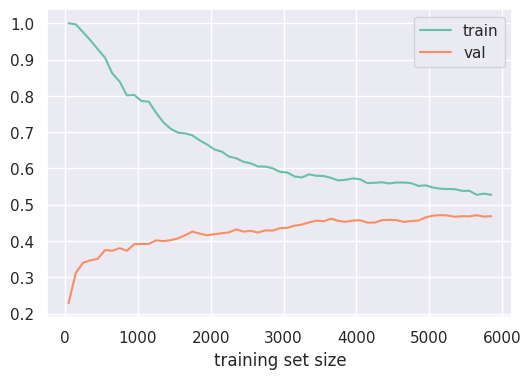

In [65]:
lsvm = LinearSVC(random_state=7, max_iter=10000)

plot_learning_curves(lsvm, Xtrain, ytrain)

# Evaluate on test

Precision: 0.4849024275971769
Recall: 0.43145299693963357
F score: 0.447631625416407


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


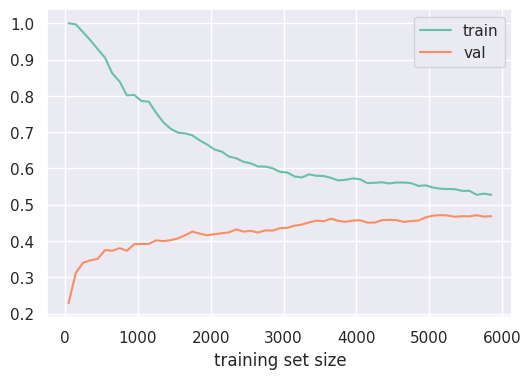

In [66]:
# re-train the best model found during cross-validation

lsvm = LinearSVC(random_state=7, max_iter=10000).fit(Xtrain, ytrain)
yhat = lsvm.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")


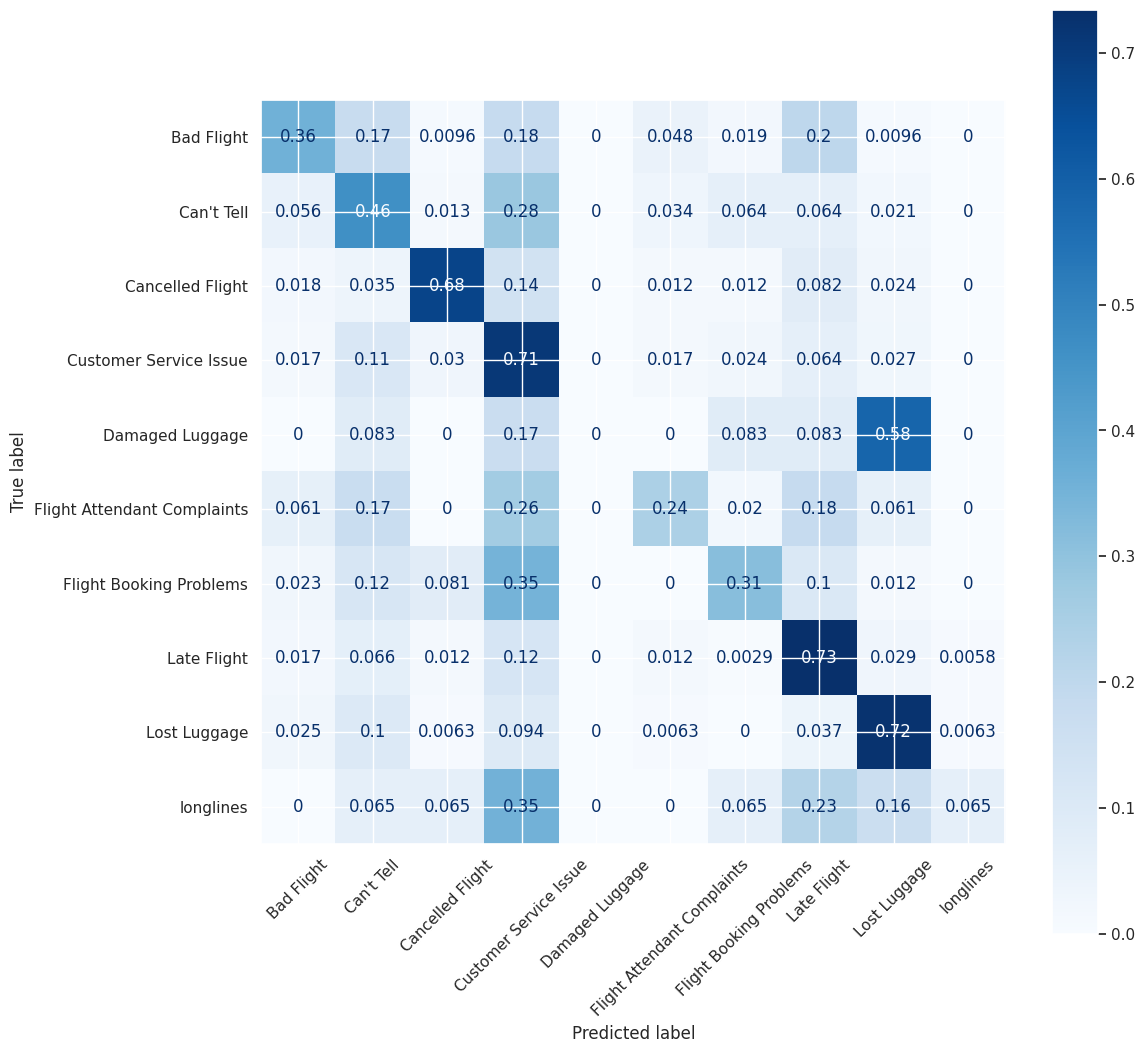

In [67]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (12, 12)

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lsvm, Xtest, ytest,
                                 display_labels=lsvm.classes_,
                                 xticks_rotation=45,
                                 cmap='Blues',
                                 normalize='true')